In [1]:
import awkward as ak
import numpy as np
import time
import sys
print(sys.executable)
from coffea import util
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
import mplhep as hep
import matplotlib.pyplot as plt
import lpcjobqueue
plt.style.use([hep.style.CMS, hep.style.firamath])
import hist
from hist.intervals import ratio_uncertainty
import pickle

/srv/.env/bin/python


In [2]:
%load_ext autoreload
%autoreload 2

from python.plugins import runCoffeaJob
from python.triggerProcessor import triggerProcessor, applyPrescales
from dask.distributed import Client

In [3]:
# in_year = '2016APV'
# data_bool = True
# processor = triggerProcessor(year = in_year, trigger = 'AK8PFJet', data = data_bool)
# datastring = "JetHT" if processor.data == True else "QCDsim"
# if processor.data==False and winterfell:
#     filename = "QCD_flat.json"
# elif processor.data==False:
#     filename = "fileset_QCD.json"
# else:
#     filename = "fileset_JetHT_wRedirs.json"
#     # filename = "datasets_JetHT_NOAK8PFHLT.json"
# result = runCoffeaJob(processor, jsonFile = filename, casa = False, dask = True, testing = False, year = processor.year, data = processor.data)
# with open('coffeaOutput/triggerAssignmentFinept_{}_{}_{}.pkl'.format(datastring, processor.year, processor.trigger), "wb") as f:
#     pickle.dump( result, f)

In [4]:
# in_year = '2016'
# data_bool = True
# processor = triggerProcessor(year = in_year, trigger = 'AK8PFJet', data = data_bool)
# datastring = "JetHT" if processor.data == True else "QCDsim"
# if processor.data==False and winterfell:
#     filename = "QCD_flat.json"
# elif processor.data==False:
#     filename = "fileset_QCD.json"
# else:
#     filename = "fileset_JetHT_wRedirs.json"
#     # filename = "datasets_JetHT_NOAK8PFHLT.json"
# result = runCoffeaJob(processor, jsonFile = filename, casa = False, dask = True, testing = False, year = processor.year, data = processor.data)
# with open('coffeaOutput/triggerAssignmentFinept_{}_{}_{}.pkl'.format(datastring, processor.year, processor.trigger), "wb") as f:
#     pickle.dump( result, f)

In [5]:
# in_year = '2017'
# data_bool = True
# processor = triggerProcessor(year = in_year, trigger = 'AK8PFJet', data = data_bool)
# datastring = "JetHT" if processor.data == True else "QCDsim"
# if processor.data==False and winterfell:
#     filename = "QCD_flat.json"
# elif processor.data==False:
#     filename = "fileset_QCD.json"
# else:
#     filename = "fileset_JetHT_wRedirs.json"
#     # filename = "datasets_JetHT_NOAK8PFHLT.json"
# result = runCoffeaJob(processor, jsonFile = filename, casa = False, dask = True, testing = False, year = processor.year, data = processor.data)
# with open('coffeaOutput/triggerAssignmentFinept_{}_{}_{}.pkl'.format(datastring, processor.year, processor.trigger), "wb") as f:
#     pickle.dump( result, f)

In [6]:
# in_year = '2018'
# data_bool = True
# processor = triggerProcessor(year = in_year, trigger = 'AK8PFJet', data = data_bool)
# datastring = "JetHT" if processor.data == True else "QCDsim"
# if processor.data==False and winterfell:
#     filename = "QCD_flat.json"
# elif processor.data==False:
#     filename = "fileset_QCD.json"
# else:
#     filename = "fileset_JetHT_wRedirs.json"
#     # filename = "datasets_JetHT_NOAK8PFHLT.json"
# result = runCoffeaJob(processor, jsonFile = filename, casa = False, dask = True, testing =False, year = processor.year, data = processor.data)
# with open('coffeaOutput/triggerAssignmentFinept_{}_{}_{}.pkl'.format(datastring, processor.year, processor.trigger), "wb") as f:
#     pickle.dump( result, f)

In [7]:
from scipy.optimize import minimize, curve_fit
from scipy.stats import rv_continuous, norm
from scipy.special import erf, erfinv

def fit_function(x, a, b, c, d):
    # y = a+0.5*(1-a)*(1+erf((x-b)/c))
    # y = 0.5*(1+erf((x-b)/(np.sqrt(2)*c)))
    y=a*(b+(0.5*(1-b)*(1-erf((x-c)/d))))
    return y
#### define custom error function using scipy.stats rv_continuous --> will automatically inherit MLE fit

class cust_erf(rv_continuous):
    def _pdf(self, x, a, b, c, d):
        # return a+0.5*(1-a)*(1+erf((x-b)/c))
        return a*(b+0.5*(1-b)*(1-erf((x-c)/d)))
        # return 0.5*(1+erf((x-b)/(np.sqrt(2)*c)))
    #### use rv_continuous scale and loc to compute x->(x-loc)/scale
fit_func = cust_erf(name='erf')
print("rv_cont fit function: ", fit_func)

#### params are b,c
                      
                      
def fit_trigEff(x, data):
    #x is the pt bin centers; data is the efficiency values
    x0 = [1, 0, np.min(x), -np.min(x)/10]
    popt, pcov = curve_fit(fit_function, x, data, p0 = x0)
    # b, c, loc, scale = fit_func.fit(data, *popt, floc = 0., fscale = 1.0)
    print("Basic fit results: ", popt)
    return popt

from python.plugins import checkdir
def plot_turnOn(result, HLT, label):
    hist_trigEff = result['hist_trigEff_ptCut']
    hist_trigRef = result['hist_trigRef']
    hist_pt = result['hist_pt']
    HLT_paths = [path for path in list(hist_trigEff.project("HLT_cat").axes[0])]
    dataset = hist_trigEff[{"HLT_cat":slice(0,hist.overflow-1,sum)}].axes[0][0]
    os_path = 'plots/triggerStudies'+ dataset+'/'
    checkdir(os_path)
    print('HLT_paths:', HLT_paths)
    trigThresh = [int(path.replace(HLT, '')) for path in HLT_paths]
    print("Trig threshs's ", trigThresh)
    turnOnPts = {}
    turnOnPts_ptCut = {}
    for i in np.arange(len(HLT_paths)):
        path = HLT_paths[i]
        print("Path = ", path, " for iteration ", i)
        #print("dataset: ", dataset)
        # print("trigeffvalues for path: ", hist_trigEff[{"HLT_cat":path}])
        #### numerator is number of events that belong to trigger path below and have pt > current trigger thresh
        numerator = hist_trigEff[{"HLT_cat":path}].values()[0]
        #### denominator is number of events in trigger below
        denominator = hist_trigRef[{"HLT_cat":path}].values()[0]
        print("Numerator  values ", np.sum(numerator))
        print("Denominator values ", np.sum(denominator))
        num = numerator[denominator > 0]
        denom = denominator[denominator > 0]
        efficiency = num / denom
        eff_hist = np.divide(
                hist_trigEff[{"HLT_cat":path}].values(),
                hist_trigRef[{"HLT_cat":path}].values(),
                out=np.empty(np.array(hist_trigRef[{"HLT_cat":path}].values()).shape).fill(np.nan),
                where=hist_trigRef[{"HLT_cat":path}].values()!= 0)[0]
        err_up, err_dn = ratio_uncertainty(hist_trigEff[{"HLT_cat":path}].values(), hist_trigRef[{"HLT_cat":path}].values(), 'efficiency')
        # print(err_up[0], err_dn[0])
        eff_hist_err = np.array([np.divide(
                np.sqrt(hist_trigEff[{"HLT_cat":path}].values())/2,
                hist_trigRef[{"HLT_cat":path}].values(),
                out=np.empty(np.array(hist_trigRef[{"HLT_cat":path}].values()).shape).fill(np.nan),
                where=hist_trigRef[{"HLT_cat":path}].values()!= 0)[0], np.zeros_like(hist_trigRef[{"HLT_cat":path}].values())[0]])
        pt_centers = hist_trigEff.axes['pt'].centers[denominator > 0]
        # print("Pt centers: ", pt_centers)
        # print("Pt edges: ",  hist_trigEff.axes['pt'].edges)
        #### plot original numerator and denominator histograms
        fig, ax = plt.subplots(1, 1)
        hist_trigEff[{"HLT_cat":path}].plot1d(ax=ax)
        hist_trigRef[{"HLT_cat":path}].plot1d(ax=ax)
        ax.set_title("Events in HLT " + HLT_paths[i-1])
        ax.set_xlabel("Leading Jet pT (GeV)")
        ax.set_ylim(1, None)
        ax.set_yscale('log')
        print("min of efficiency ", np.nanmin(eff_hist))
        print("min of efficiency ", np.nanmin(efficiency))
        ax.legend(["Numerator", "Numerator_ptCut", "Denominator"])
        plt.savefig(os_path + 'numDenom_HLT_' + path + ".png")
        #### Make custom fit function for the efficiencies
        if len(efficiency) > 0:
            fig, ax = plt.subplots(1, 1)
            ax.set_ylim([-0.01, 1.1])
            ### only fit points after trigger threshold
            eff_turnon_id = np.min(np.argwhere(trigThresh[i] <= pt_centers))
            print("turn on pt ", trigThresh[i])
            if 140 > trigThresh[i]:
                print( trigThresh[i])
                xdata = pt_centers[eff_turnon_id:eff_turnon_id+30]
                ydata = efficiency[eff_turnon_id:eff_turnon_id+30]
            elif 260 > trigThresh[i] >= 140:
                xdata = pt_centers[eff_turnon_id+i+3:eff_turnon_id+40]
                ydata = efficiency[eff_turnon_id+i+3:eff_turnon_id+40]
            elif 320 > trigThresh[i] >= 260:
                xdata = pt_centers[eff_turnon_id+1:eff_turnon_id+40]
                ydata = efficiency[eff_turnon_id+1:eff_turnon_id+40]
            elif 450 > trigThresh[i] >= 320:
                xdata = pt_centers[eff_turnon_id+10:eff_turnon_id+50]
                ydata = efficiency[eff_turnon_id+10:eff_turnon_id+50]
            else:
                print(eff_turnon_id)
                print(pt_centers[eff_turnon_id+13])
                print(pt_centers[eff_turnon_id+50])
                xdata = pt_centers[eff_turnon_id+10:eff_turnon_id+60]
                ydata = efficiency[eff_turnon_id+10:eff_turnon_id+60]
            popt = fit_trigEff(xdata, ydata)
            print("regular fit results ", popt)
            xpts = np.linspace(pt_centers[eff_turnon_id], 2400, int((2400-pt_centers[eff_turnon_id])))
            ### turn on point is pt value when efficiency reaches 0.99 --> solve fitted equation
            a, b, c, d = popt
            xdata = pt_centers[eff_turnon_id:]
            ydata = efficiency[eff_turnon_id:]
            def NLL(params):
                a = params[0]
                b = params[1]
                c = params[2]
                d = params[3]
                #y = a+0.5*(1-a)*(1+erf((xdata-b)/c))
                y = a*(b+0.5*(1-b)*(1-erf((xdata-c)/d)))
                return -1*norm(y, params[2]).logpdf(ydata).sum()
            res = minimize(NLL, [popt[0], popt[1], popt[2], 1])
            # res = minimize(NLL, [0, np.min(xdata), np.min(xdata)/5, 1])
            a_mle, b_mle, c_mle , s_mle = res.x
            print("MLE results ", res.x)
            print("regular fit result ", popt)
            # to_pt = (np.sqrt(2)*c*erfinv(2*0.99-1)) + b
            # to_pt = b+c*erfinv((2*0.99-1-a)/(1-a))
            # to_pt =c+d*erfinv(1-((2*0.99)/(a*(b+1))))
            to_pt =c+d*erfinv(1-((0.97/a - b)/(0.5*(1-b)))) 
            print("turn on pt ", to_pt)
            # to_pt_mle = (np.sqrt(2)*c_mle*erfinv(2*0.99-1)) + b_mle
            to_pt_mle = b_mle+(c_mle*erfinv(1-(2*(0.99+a_mle)/(1-a_mle))))
            turnOnPts[path] = [to_pt, to_pt_mle]
            hep.histplot(eff_hist, hist_trigEff.axes['pt'].edges, ax = ax, label='HLT_'+path, yerr=np.array([err_up[0],err_dn[0]]), histtype='errorbar', color = 'black', marker =["o"], markersize=4,)
            ax.plot(xpts, fit_function(xpts, *popt), label = "Fit; to_pt = %.f"%to_pt, color='red')
            hep.cms.label("Preliminary", lumi = label, data = True, loc=0, ax=ax, fontsize=18);
            # ax.plot(xpts, fit_function(xpts, a_mle, b_mle, c_mle), label = "MLE fit; to_pt = %.f"%to_pt_mle)
            ax.set_xlabel("Leading Jet pT (GeV)")
            print("plotting lower lim ", pt_centers[(eff_turnon_id-1)])
            ax.set_xlim(50*i,1500)
            ax.legend()
            plt.savefig(os_path + 'efficiency_HLT_'+path + ".png")
    #### plot total leading jet pt for reference
    fig, ax = plt.subplots(1, 1)
#     hist_pt.plot1d(ax=ax)
    pt_hist = hist_trigEff[{"dataset":sum}]
    pt_hist.plot1d(ax=ax, overlay="HLT_cat", stack = True)
    ax.set_title("All events")
    ax.set_xlabel("Leading Jet pT (GeV)")
    ax.set_ylim(1, None)
    ax.set_yscale('log')
    ax.set_xlim([180., 3200.])
    plt.legend()
    plt.savefig(os_path + 'HLT_' + path + ".png")
    
    return turnOnPts


# lumi = {'2018' : 59.74,
#         '2017': 41.48,
#         '2016': 36.33 
#        }

#'2016APV':19.5
#"2016":16.8

rv_cont fit function:  <__main__.cust_erf object at 0x7f3fa4da8970>


In [8]:
# HLT = 'AK8PFJet'
# # with open('coffeaOutput/triggerAssignmentL1pt_JetHT_2016_AK8PFJet.pkl', "rb") as f:
# with open('coffeaOutput/triggerAssignmentFinept_JetHT_2016_AK8PFJet.pkl', "rb") as f:
#     result = pickle.load( f )
# print(result)
# turnOnPts = plot_turnOn(result, HLT, label=r'Late 2016 - 16.8' )
# print(turnOnPts)

HLT_paths: ['AK8PFJet80', 'AK8PFJet140', 'AK8PFJet200', 'AK8PFJet260', 'AK8PFJet320', 'AK8PFJet400', 'AK8PFJet450', 'AK8PFJet500', 'AK8PFJet60']
Trig threshs's  [80, 140, 200, 260, 320, 400, 450, 500, 60]
Path =  AK8PFJet80  for iteration  0
Numerator  values  47765.0
Denominator values  48417.0
min of efficiency  0.0
min of efficiency  0.9772883688919477
turn on pt  80
80
Basic fit results:  [   0.99970088 -341.97157995 -626.20444446 -295.97566113]
regular fit results  [   0.99970088 -341.97157995 -626.20444446 -295.97566113]
MLE results  [   0.99970088 -341.97157995 -626.20444446    1.        ]
regular fit result  [   0.99970088 -341.97157995 -626.20444446 -295.97566113]
turn on pt  159.69391284907874
plotting lower lim  1350.0
Path =  AK8PFJet140  for iteration  1
Numerator  values  128885.0
Denominator values  149753.0
min of efficiency  4.66336328237067e-310
min of efficiency  0.7120126782884311
turn on pt  140
Basic fit results:  [ 9.97947493e-01 -2.65454241e+03 -3.69938083e+02 -

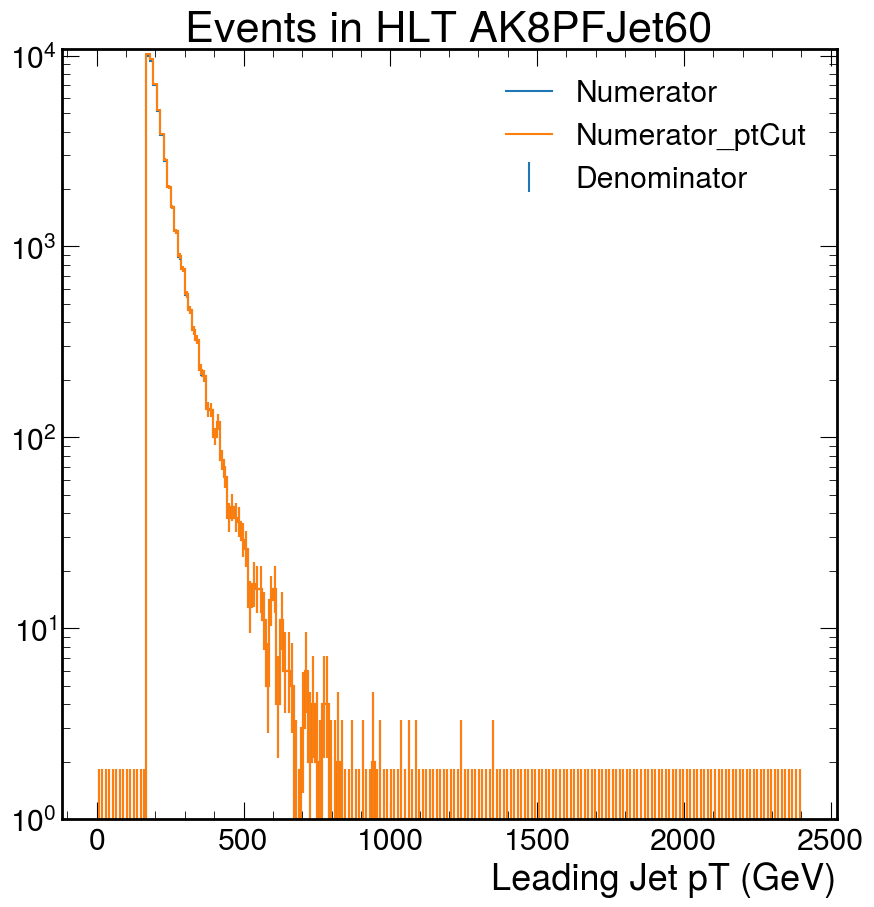

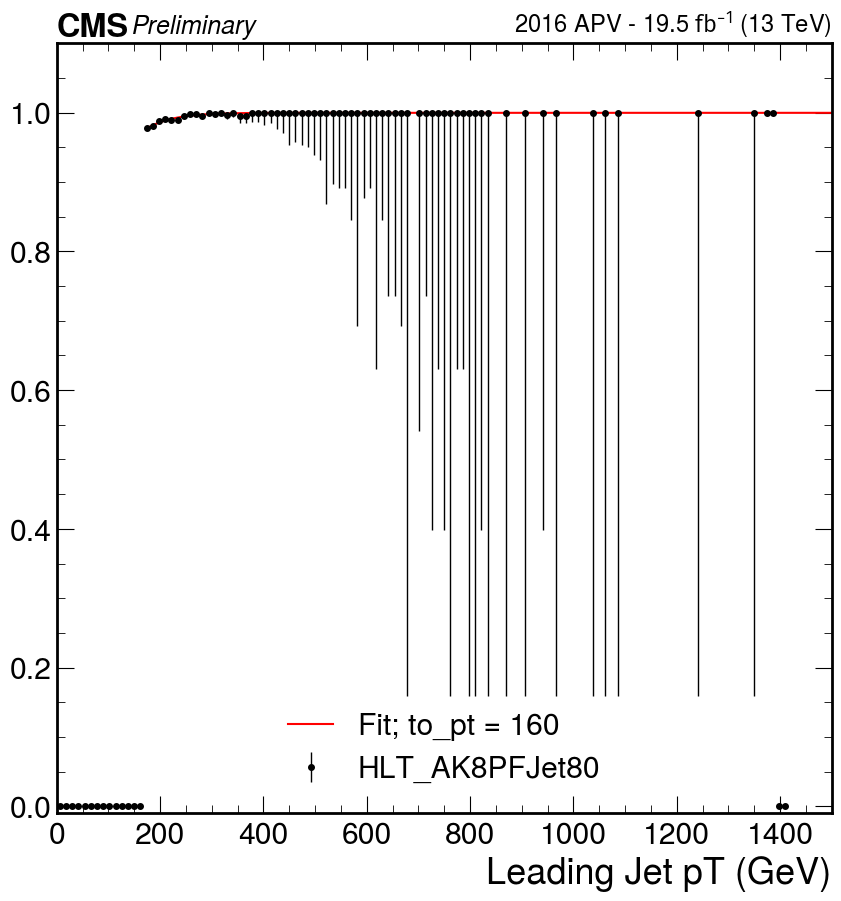

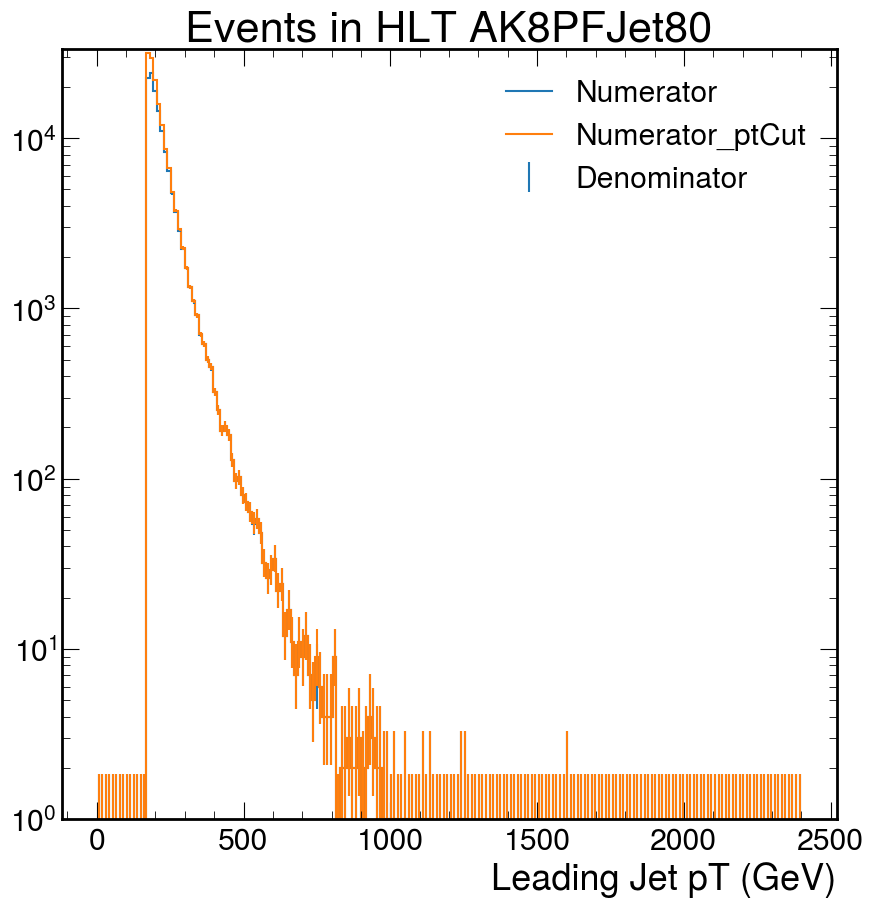

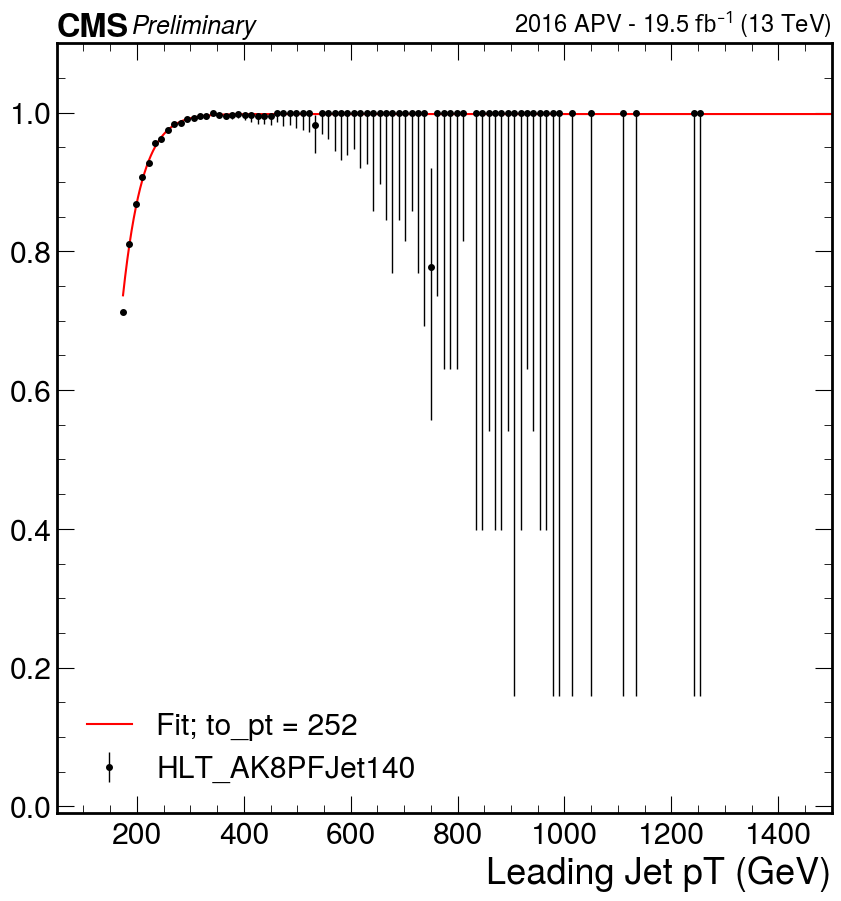

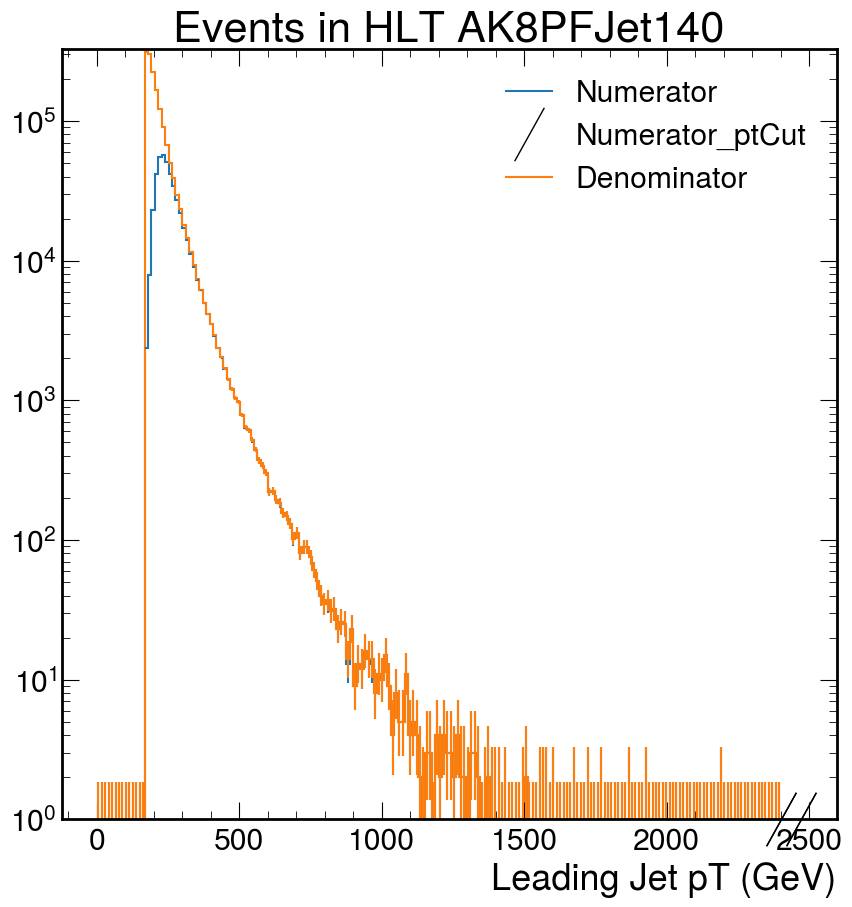

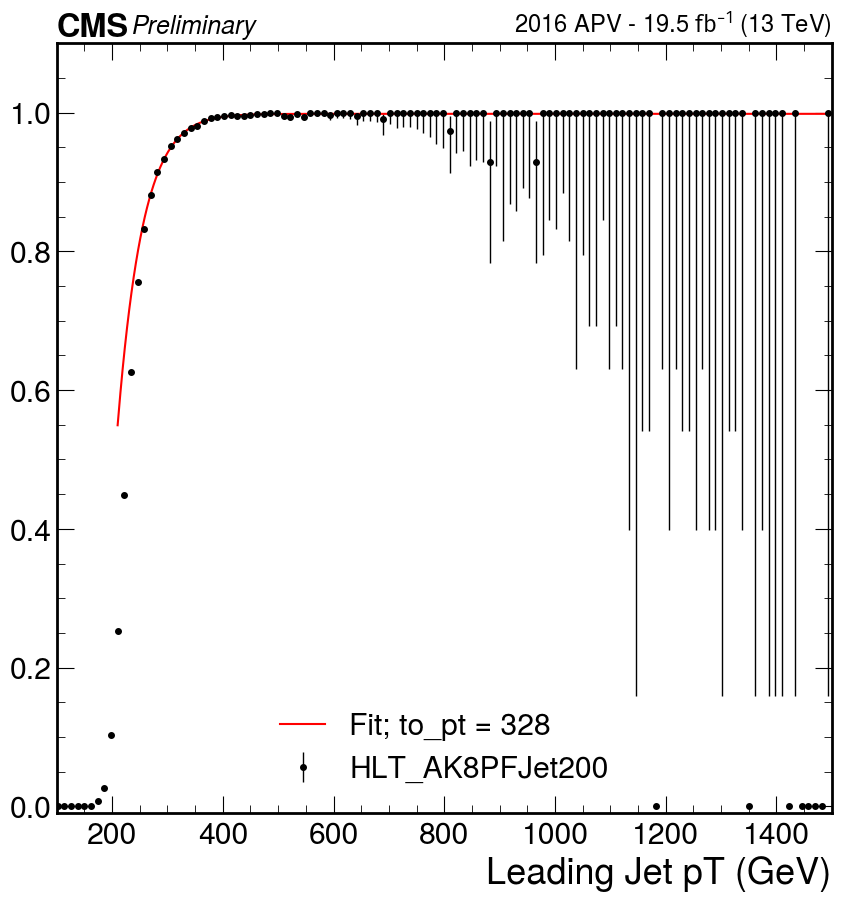

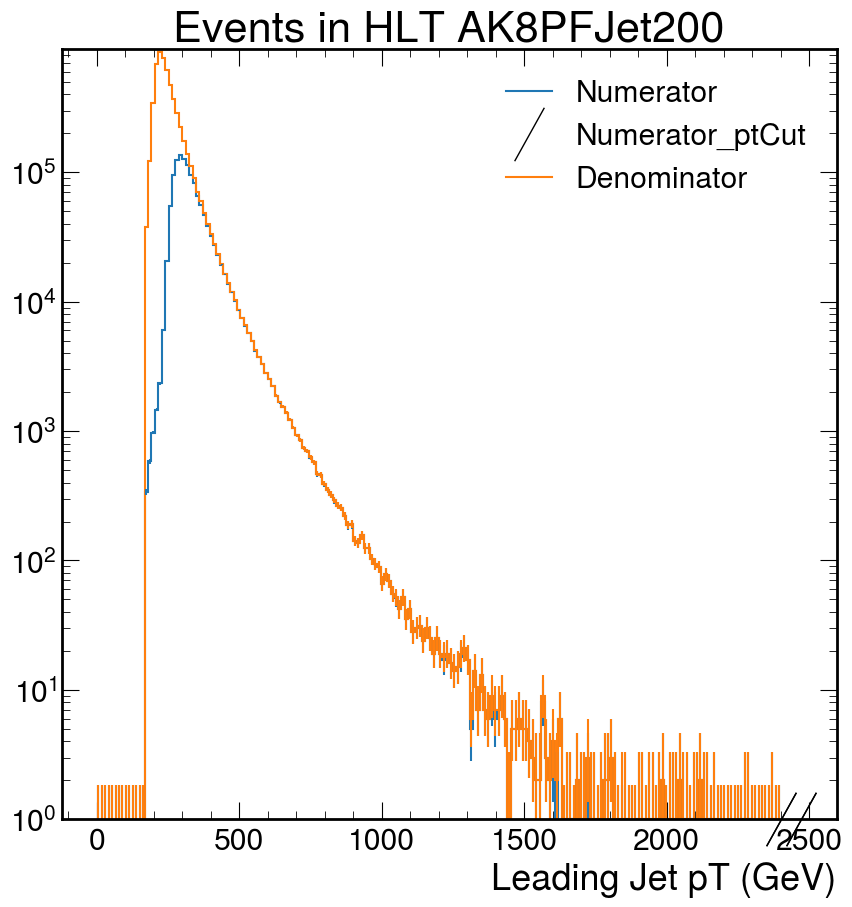

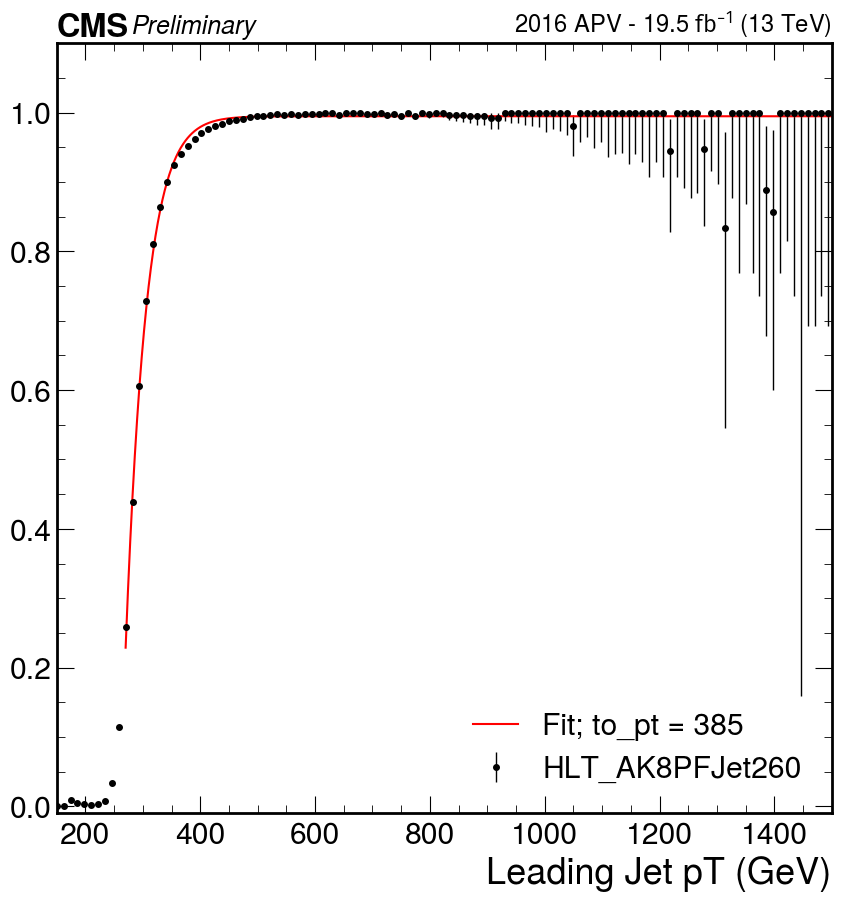

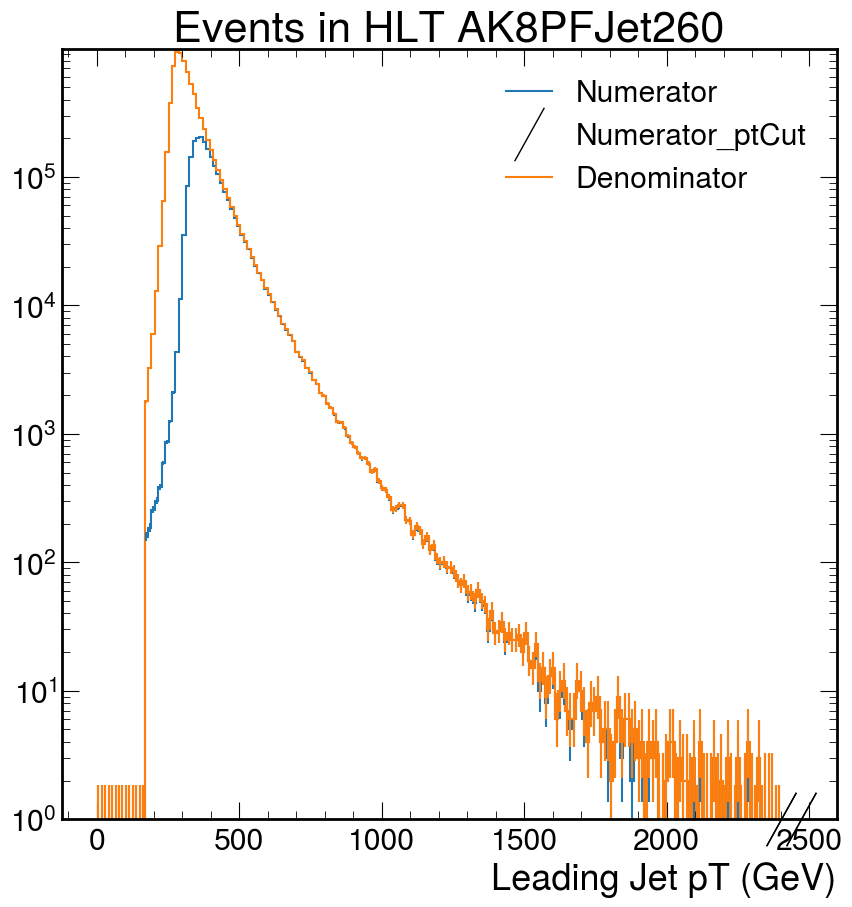

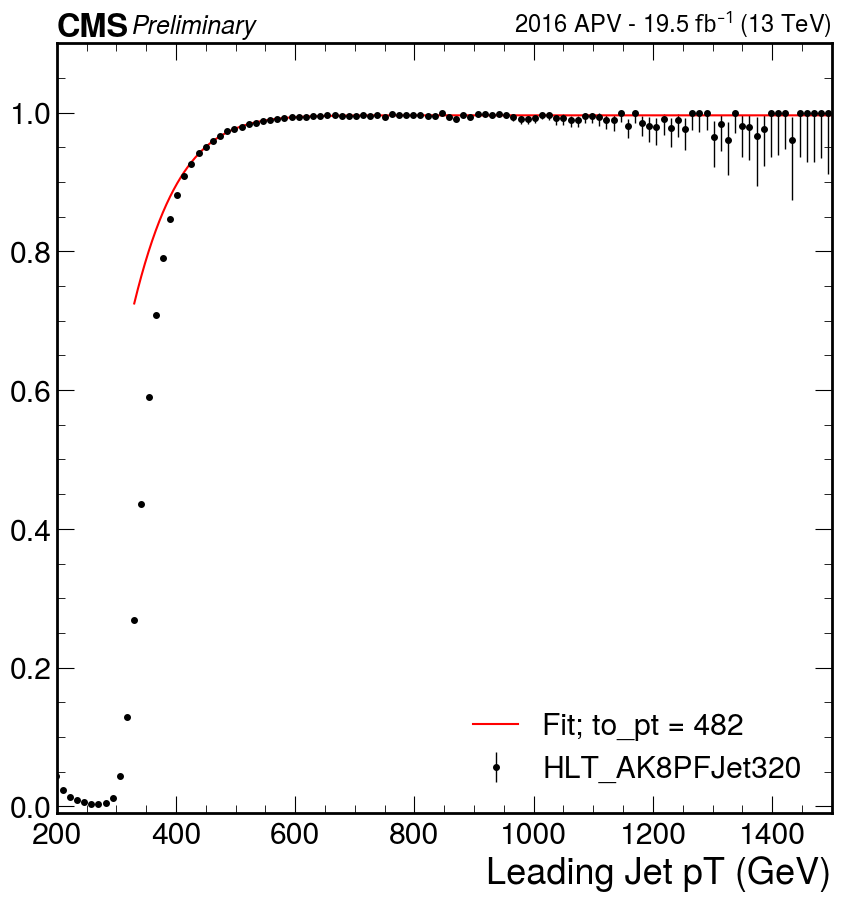

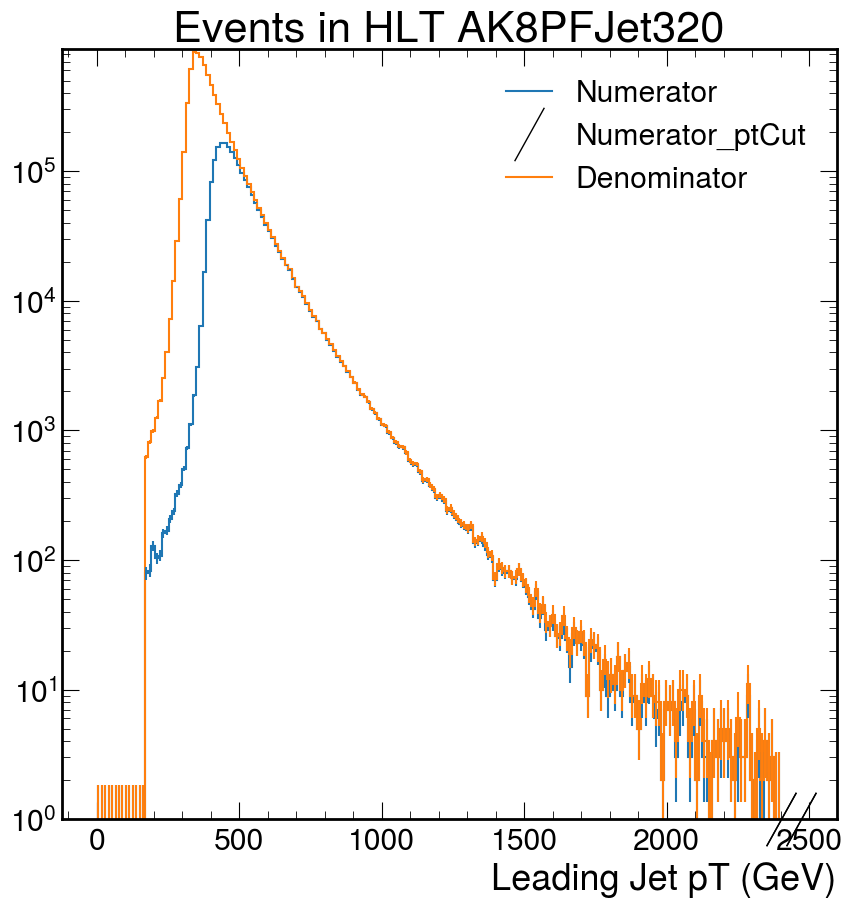

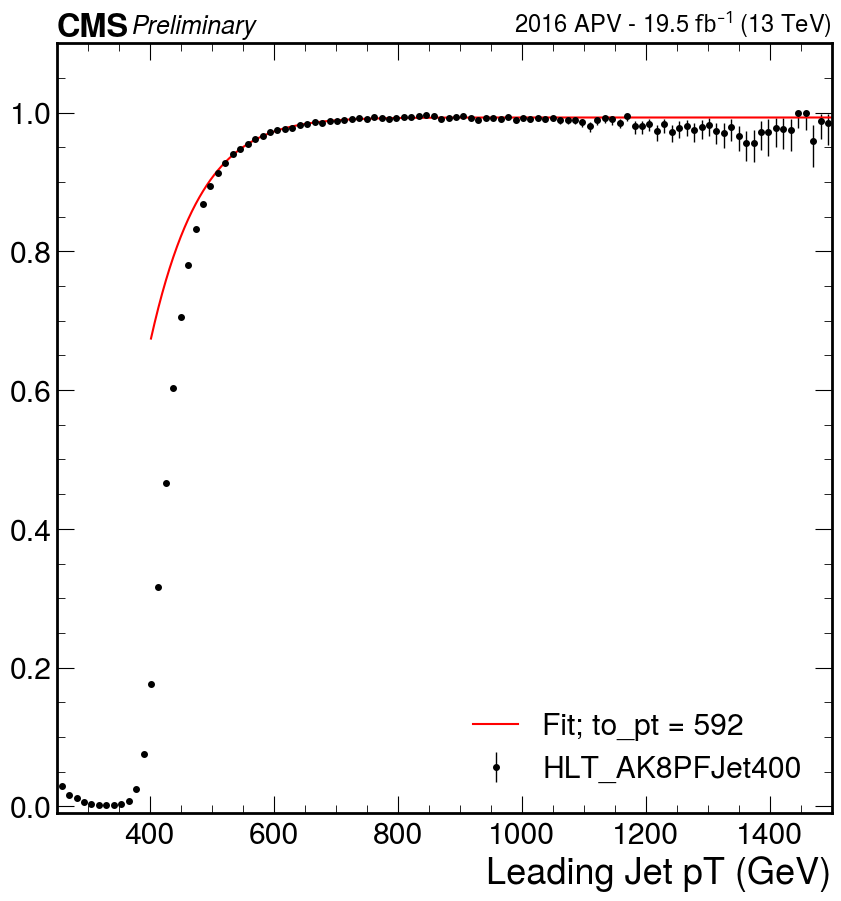

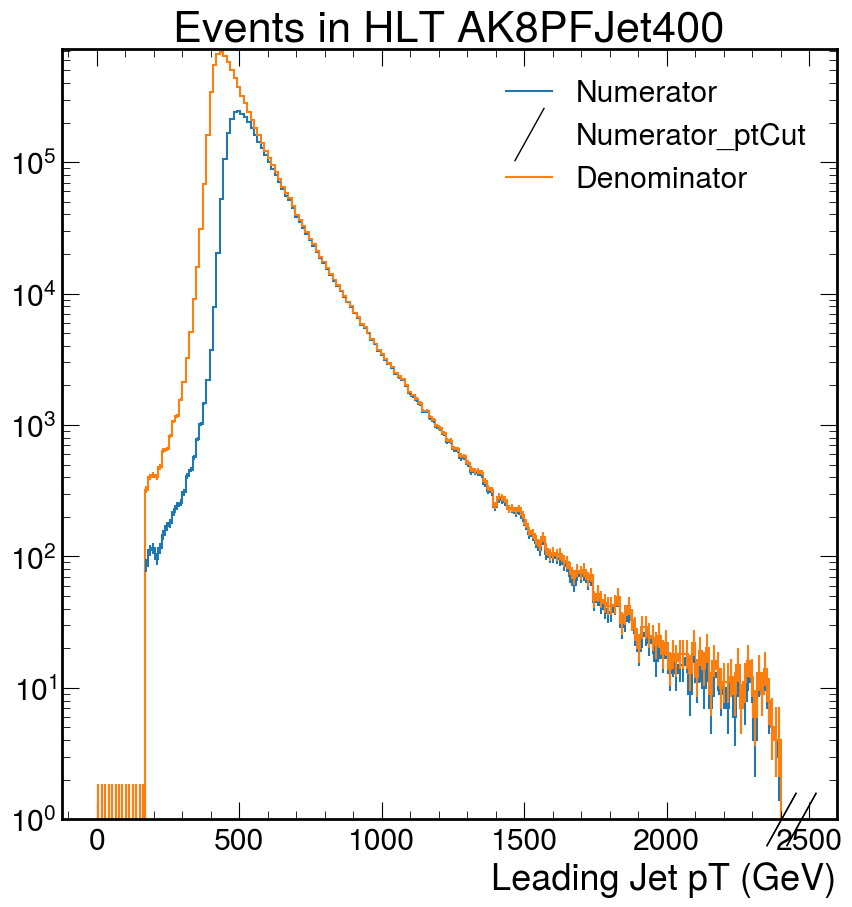

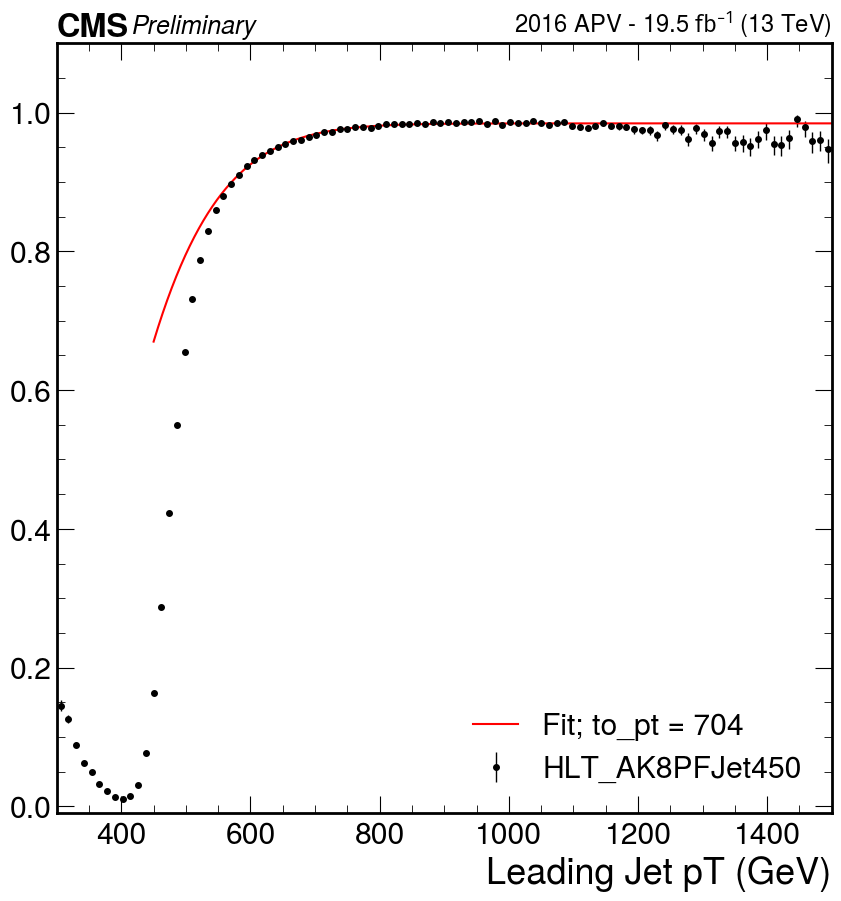

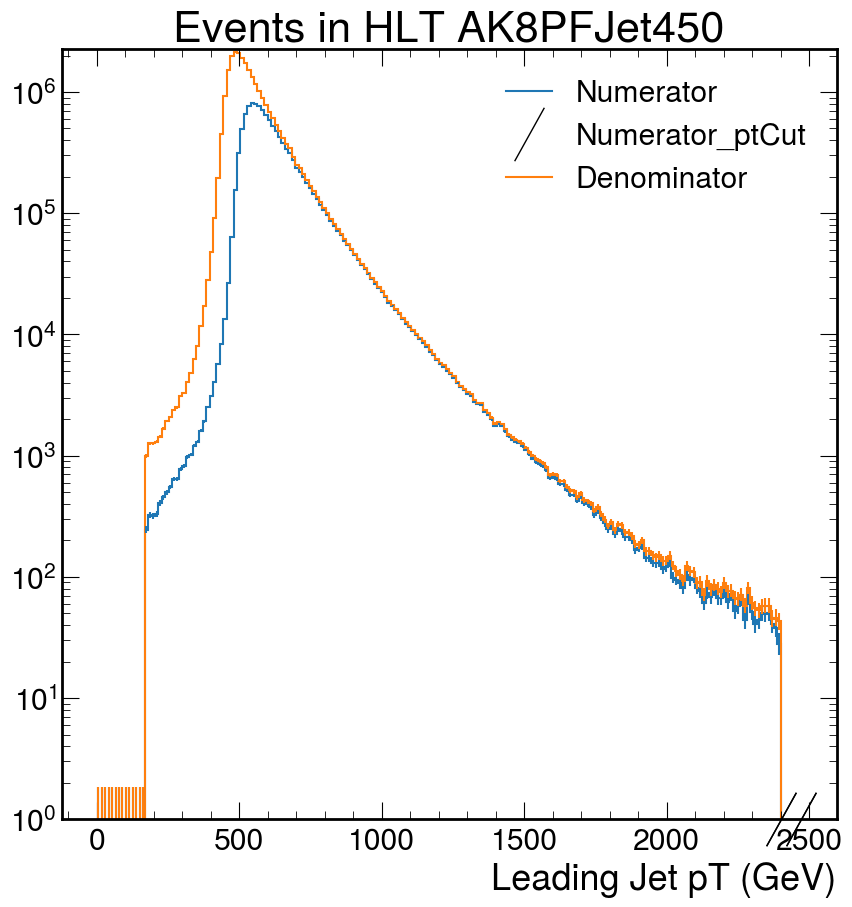

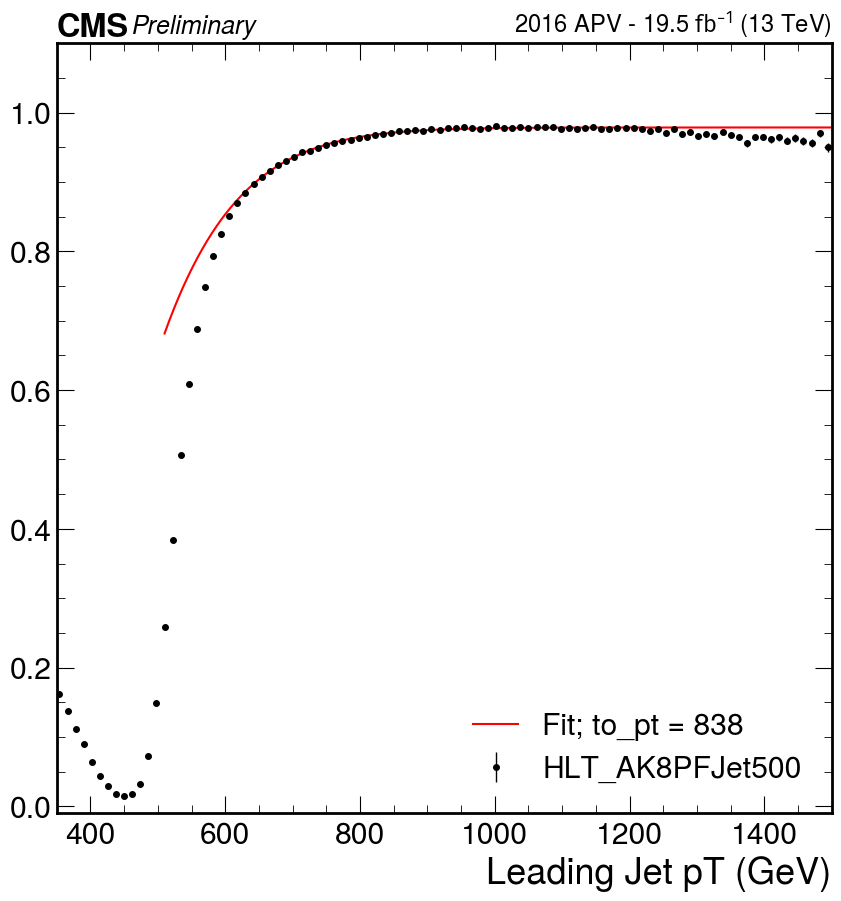

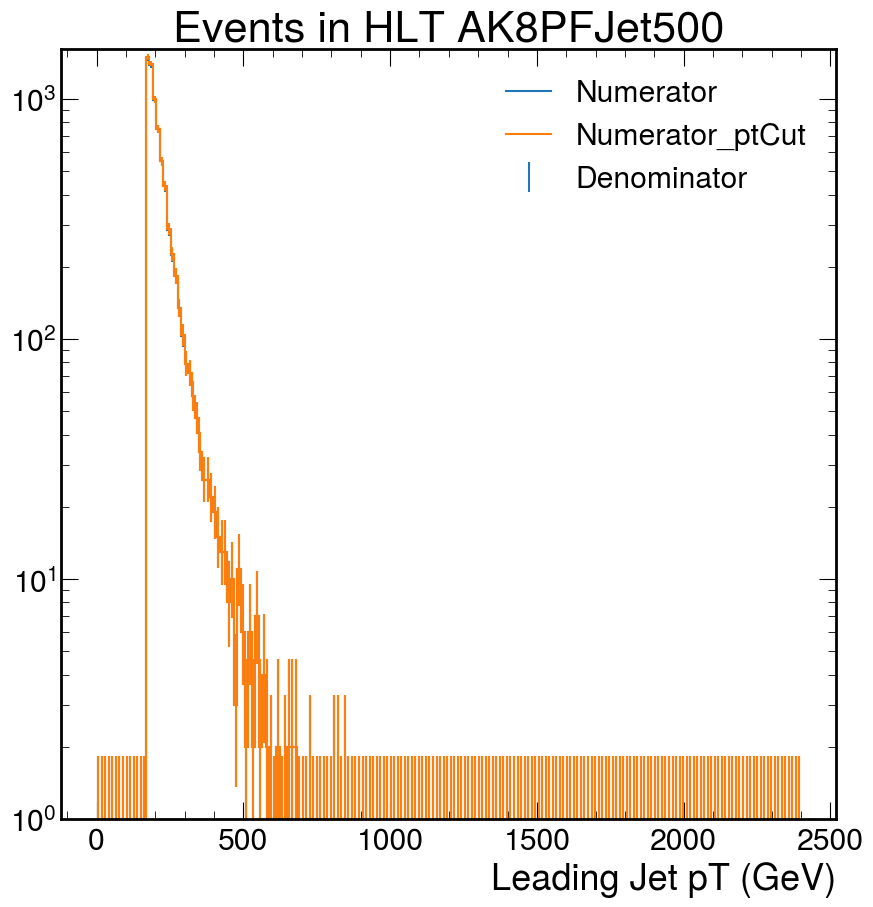

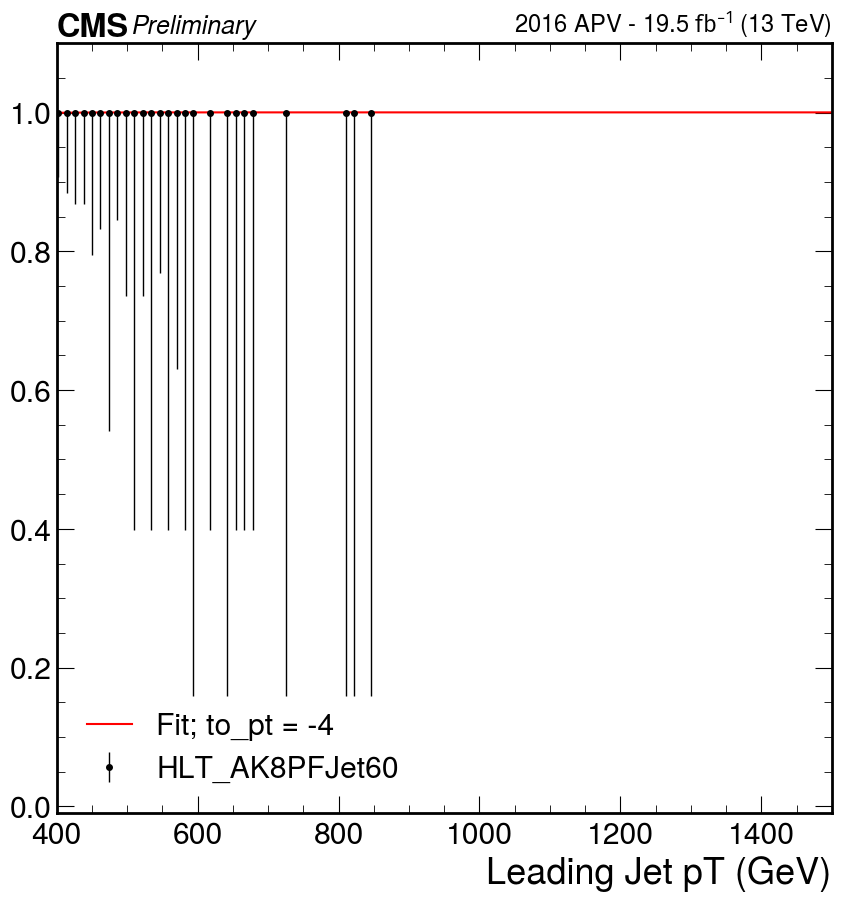

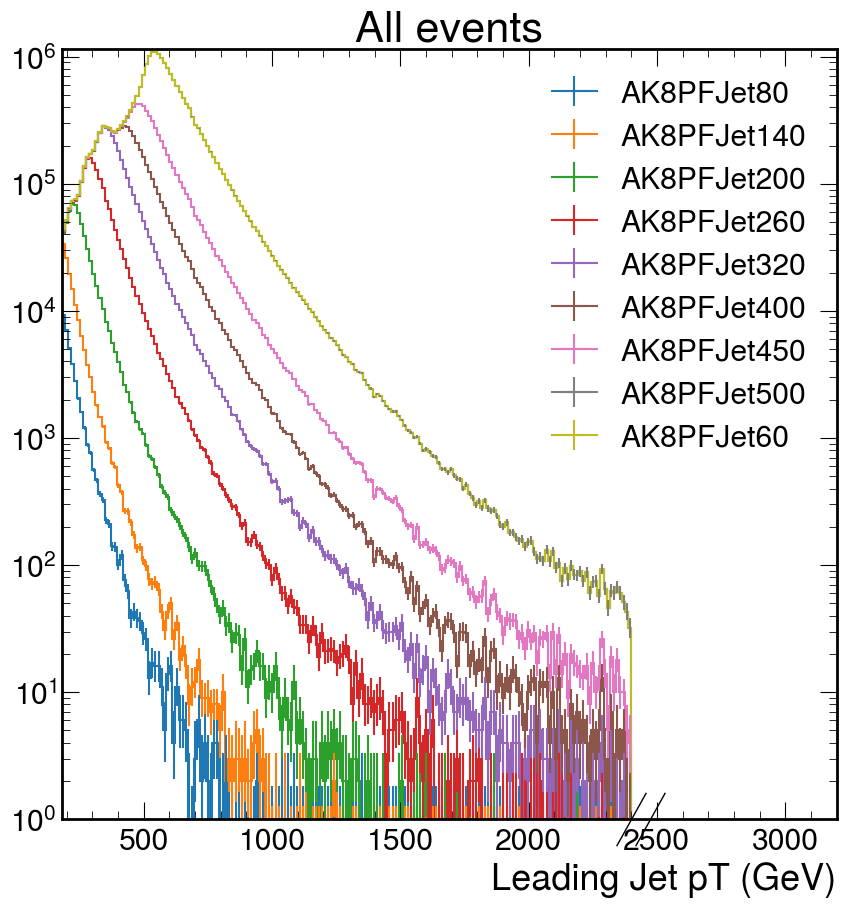

In [9]:
HLT = 'AK8PFJet'
with open('coffeaOutput/triggerAssignmentFinept_JetHT_2016APV_AK8PFJet.pkl', "rb") as f:
# with open('coffeaOutput/triggerAssignmentL1pt_JetHT_2016APV_AK8PFJet.pkl', "rb") as f:
    result = pickle.load( f )
#turnOnPts = plot_turnOn(result, HLT, label=r'2016 APV - 19.5' )
turnOnPts = plot_turnOn(result, HLT, label=r'2016 APV - 19.5' )
print(turnOnPts)

In [10]:
# HLT = 'AK8PFJet'
# with open('coffeaOutput/triggerAssignmentFinept_JetHT_2017_AK8PFJet.pkl', "rb") as f:
#     result = pickle.load( f )
# turnOnPts = plot_turnOn(result, HLT, label=r'2017 - 41.48', )
# print(turnOnPts)

In [11]:
# HLT = 'AK8PFJet'
# with open("coffeaOutput/triggerAssignmentL1pt_QCDsim_2017_PFJet.pkl", "rb") as f:
#     result = pickle.load( f )
# turnOnPts = plot_turnOn(result, HLT, label=r'2017 - 41.48')
# print(turnOnPts)

In [12]:
# HLT = 'AK8PFJet'
# with open('coffeaOutput/triggerAssignmentFinept_JetHT_2018_AK8PFJet.pkl', "rb") as f:
#     result = pickle.load(f)
# turnOnPts = plot_turnOn(result, HLT, label=r'2018 - 59.74', )
# print(turnOnPts)

In [13]:
# HLT = 'AK8PFJet'
# result = util.load('coffeaOutput/triggerAssignment_QCDsim_2018_AK8PFJet_NewHist.coffea')
# turnOnPts = plot_turnOn(result, HLT, label=r'2018 - 59.74')
# print(turnOnPts)

In [14]:
newl12016APV = {'AK8PFJet80': [216.16923461884844, 216.16927562975312], 'AK8PFJet140': [296.71777026797577, 296.71777026797577], 
                'AK8PFJet200': [387.4239725003692, 387.5431752357464], 'AK8PFJet260': [460.02791913851263, 460.1490407453397], 
                'AK8PFJet320': [552.7892181832151, 552.8233099352931], 'AK8PFJet400': [655.6163941832838, 655.7021419214718], 
                'AK8PFJet450': [667.2324051877441, 667.2592780473391], 'AK8PFJet500': [752.0119715240766, 752.0355191981981], 
                'AK8PFJet60': [178.0281362806903, 178.0281362806903]}
newl12016 = {'AK8PFJet60': [139.5571999490993, 139.5571760475624], 'AK8PFJet80': [208.43956364614138, 208.43956364614138], 
             'AK8PFJet140': [290.39564432515516, 290.39564432515516], 'AK8PFJet200': [360.602157645454, 360.7033371546764], 
             'AK8PFJet260': [458.155057383878, 458.2976702547345], 'AK8PFJet320': [550.9726581073608, 551.0117961041149], 
             'AK8PFJet400': [648.8572067859793, 648.9495011463662], 'AK8PFJet450': [733.6270392149845, 733.7119706001635], 
             'AK8PFJet500': [821.4222318279127, 821.5019209913376]}
newl12017 = {'AK8PFJet80': [160.52022125699813, 160.52022125699813], 'AK8PFJet140': [277.85271111436055, 277.85271111436055], 
             'AK8PFJet200': [381.9345155782403, 382.0671158797676], 'AK8PFJet260': [459.1656517376684, 459.2760754297681], 
             'AK8PFJet320': [562.0252237627351, 562.0891077803932], 'AK8PFJet400': [676.7400780530811, 676.8603722844096], 
             'AK8PFJet450': [747.8861635197648, 747.9988823716554], 'AK8PFJet500': [815.0991287697173, 815.2146885845864], 
             'AK8PFJet550': [878.4457460689262, 878.5671010336473], 'AK8PFJet60': [-155.2356453732673, -155.23562744714604]}
newl12018 = {'AK8PFJet60': [-332.1769145662199, -332.1769145662199], 'AK8PFJet80': [160.89471879512197, 160.89471879512197],
             'AK8PFJet140': [274.1725162164536, 274.1725162164536], 'AK8PFJet200': [395.60974887544114, 395.70166631502633], 
             'AK8PFJet260': [475.25798095173286, 475.3674070818721], 'AK8PFJet320': [571.680946693499, 571.7348681815065],
             'AK8PFJet400': [683.6533837700646, 683.7620353906178], 'AK8PFJet450': [748.9417233469158, 749.0451068661237], 
             'AK8PFJet500': [815.1757724580646, 815.2803244303279], 'AK8PFJet550': [877.3489891652127, 877.4559437721737]}
pfjet2016APV = {'PFJet80': [221.50548457646764, 245.80359414733596], 'PFJet140': [297.303773316647, 246.05359519294237], 'PFJet200': [365.1336120673918, 316.5659648509295], 'PFJet260': [460.0898921606057, 386.9210814134716], 'PFJet320': [553.8485712694877, 527.4226587472542], 'PFJet400': [692.1212907064324, 597.8446126797236], 'PFJet450': [786.8856742383937, 668.1641235688161], 'PFJet500': [979.671786337144, 738.5027375039972], 'PFJet60': [123.93335136753808, 245.72432425034089]}
pfjet2017 = {'PFJet60': [-1595.2605509849727, 245.8172950616106], 'PFJet80': [141.2310007504739, 245.87476413219088], 'PFJet140': [280.9091493524036, 246.1037096100053], 'PFJet200': [382.1752391930248, 316.6018603013339], 'PFJet260': [456.6945321808703, 386.9753107466026], 'PFJet320': [559.0924890473514, 527.4627570990666], 'PFJet400': [635.2886366274465, 597.9123835576901], 'PFJet450': [720.0475114990843, 668.218477899657], 'PFJet500': [784.9475652849118, 738.5470644051876], 'PFJet550': [840.1791041568115, 808.8847580928046]}
pfjet2018 = {'PFJet60': [-120.82126509970408, 245.73957829941662], 'PFJet80': [160.72455293363703, 245.9068171283308], 'PFJet140': [287.63426567944975, 246.0911456568046], 'PFJet200': [395.64131492903664, 316.5666543646143], 'PFJet260': [474.98390359029395, 386.9655756313947], 'PFJet320': [571.4031774653945, 527.4573398293147], 'PFJet400': [647.1060350009018, 597.8975716942707], 'PFJet450': [721.9987922839626, 668.2018280982585], 'PFJet500': [783.2202950207775, 738.5288621407296], 'PFJet550': [839.0788762823904, 808.8570322939919]}

JetHT2016_L1 = {'AK8PFJet40':0.,
                 'AK8PFJet60': 0., 
                 'AK8PFJet80': 205., 
                 'AK8PFJet140': 295., 
                 'AK8PFJet200': 379., 
                 'AK8PFJet260': 459., 
                 'AK8PFJet320': 544., 
                 'AK8PFJet400': 643., 
                 'AK8PFJet450': 702., 
                 'AK8PFJet500': 802.}
JetHT2016APV_L1 = {'AK8PFJet40':0., 
                     'AK8PFJet60': 178., 
                     'AK8PFJet80': 181., 
                     'AK8PFJet140': 295., 
                     'AK8PFJet200': 389., 
                     'AK8PFJet260': 463., 
                     'AK8PFJet320': 554., 
                     'AK8PFJet400': 664., 
                     'AK8PFJet450': 733., 
                     'AK8PFJet500': 838.}
JetHT2017_L1 = {'AK8PFJet40':0.,
               'PFJet60': 0., 
                    'PFJet80': 168., 
                    'PFJet140': 267., 
                    'PFJet200': 359.,
                    'PFJet260': 447., 
                    'PFJet320': 537., 
                    'PFJet400': 646., 
                    'PFJet450': 718., 
                    'PFJet500': 791., 
                    'PFJet550': 887.}
JetHT2018_L1 = {'AK8PFJet15': 0.,
                 'AK8PFJet25': 0.,
                 'AK8PFJet40': 0.,
                 'AK8PFJet60': 0.,
                 'AK8PFJet80': 177., 
                 'AK8PFJet140': 281., 
                 'AK8PFJet200': 394., 
                 'AK8PFJet260': 484., 
                 'AK8PFJet320': 570., 
                 'AK8PFJet400': 683., 
                 'AK8PFJet450': 751., 
                 'AK8PFJet500': 817., 
                 'AK8PFJet550': 884.}

JetHT2016_new = {'AK8PFJet40':0.,
                 'AK8PFJet60': 100., 
                 'AK8PFJet80': 200., 
                 'AK8PFJet140': 260., 
                 'AK8PFJet200': 350., 
                 'AK8PFJet260': 420., 
                 'AK8PFJet320': 530., 
                 'AK8PFJet400': 620., 
                 'AK8PFJet450': 690., 
                 'AK8PFJet500': 740.}
JetHT2016APV_new = {'AK8PFJet40':0., 
                     'AK8PFJet60': 0, 
                     'AK8PFJet80': 220., 
                     'AK8PFJet140': 270., 
                     'AK8PFJet200': 360., 
                     'AK8PFJet260': 440., 
                     'AK8PFJet320': 530., 
                     'AK8PFJet400': 630., 
                     'AK8PFJet450': 690., 
                     'AK8PFJet500': 750.}
JetHT2017_new = {'AK8PFJet40':0.,
                 'AK8PFJet60': 0., 
                 'AK8PFJet80': 200., 
                 'AK8PFJet140': 260., 
                 'AK8PFJet200': 340., 
                 'AK8PFJet260': 420., 
                 'AK8PFJet320': 530., 
                 'AK8PFJet400': 620., 
                 'AK8PFJet450': 680., 
                 'AK8PFJet500': 745., 
                 'AK8PFJet550': 807.}
JetHT2018_new = {'AK8PFJet15': 0.,
                 'AK8PFJet25': 0.,
                 'AK8PFJet40': 0.,
                 'AK8PFJet60': 0.,
                 'AK8PFJet80': 0., 
                 'AK8PFJet140': 260., 
                 'AK8PFJet200': 360., 
                 'AK8PFJet260': 440., 
                 'AK8PFJet320': 550., 
                 'AK8PFJet400': 630., 
                 'AK8PFJet450': 700., 
                 'AK8PFJet500': 750., 
                 'AK8PFJet550': 810.}

In [15]:
# in_year = '2016APV'
# data_bool = True
# winterfell = False
# processor = applyPrescales(year = in_year, trigger = 'AK8PFJet', turnOnPts = np.array(list(JetHT2016APV_L1.values())), data = data_bool)
# datastring = "JetHT" if processor.data == True else "QCDsim"
# if processor.data==False and winterfell:
#     filename = "QCD_flat_files.json"
# elif processor.data==False:
#     filename = "fileset_QCD.json"
# else:
#     filename = "fileset_JetHT_wRedirs.json"
# result = runCoffeaJob(processor, jsonFile = filename, dask=True, testing = False , year = processor.year, data = processor.data)
# with open('coffeaOutput/applyPrescales_latest_{}_{}_{}.pkl'.format(datastring, processor.year, processor.trigger), "wb") as f:
#     pickle.dump( result, f)

In [16]:
# in_year = '2016'
# data_bool = True
# winterfell = False
# processor = applyPrescales(year = in_year, trigger = 'AK8PFJet', turnOnPts = np.array(list(JetHT2016_L1.values())), data = data_bool)
# datastring = "JetHT" if processor.data == True else "QCDsim"
# if processor.data==False and winterfell:
#     filename = "QCD_flat_files.json"
# elif processor.data==False:
#     filename = "fileset_QCD.json"
# else:
#     filename = "fileset_JetHT_wRedirs.json"
# result = runCoffeaJob(processor, jsonFile = filename, dask=True, testing = False , year = processor.year, data = processor.data)
# with open('coffeaOutput/applyPrescales_latest_{}_{}_{}.pkl'.format(datastring, processor.year, processor.trigger), "wb") as f:
#     pickle.dump( result, f)

In [17]:
# in_year = '2017'
# data_bool = True
# winterfell = False
# processor = applyPrescales(year = in_year, trigger = 'AK8PFJet', turnOnPts = np.array(list(JetHT2017_L1.values())), data = data_bool)
# datastring = "JetHT" if processor.data == True else "QCDsim"
# if processor.data==False and winterfell:
#     filename = "QCD_flat_files.json"
# elif processor.data==False:
#     filename = "fileset_QCD.json"
# else:
#     filename = "fileset_JetHT_wRedirs.json"
# result = runCoffeaJob(processor, jsonFile = filename, dask=True, testing = False, year = processor.year, data = processor.data)
# with open('coffeaOutput/applyPrescalesTest_{}_{}_{}.pkl'.format(datastring, processor.year, processor.trigger), "wb") as f:
#     pickle.dump( result, f)

In [18]:
# in_year = '2018'
# data_bool = True
# winterfell = False
# processor = applyPrescales(year = in_year, trigger = 'AK8PFJet', turnOnPts = np.array(list(JetHT2018_L1.values())), data = data_bool)
# datastring = "JetHT" if processor.data == True else "QCDsim"
# if processor.data==False and winterfell:
#     filename = "QCD_flat_files.json"
# elif processor.data==False:
#     filename = "fileset_QCD.json"
# else:
#     filename = "fileset_JetHT_wRedirs.json"
# result = runCoffeaJob(processor, jsonFile = filename, dask=True, testing = False , year = processor.year, data = processor.data)
# with open('coffeaOutput/applyPrescales_{}_{}_{}.pkl'.format(datastring, processor.year, processor.trigger), "wb") as f:
#     pickle.dump( result, f)

In [19]:
# in_year = '2016APV'
# data_bool = True
# winterfell = True
# processor = applyPrescales(year = in_year, trigger = 'PFJet', turnOnPts = np.array(list(JetHT2016APV_ver2.values())), data = data_bool)
# datastring = "JetHT" if processor.data == True else "QCDsim"
# if processor.data==False and winterfell:
#     filename = "QCD_flat_files.json"
# elif processor.data==False:
#     filename = "fileset_QCD.json"
# else:
#     filename = "datasets_JetHT_NOAK8PFHLT.json"
# result = runCoffeaJob(processor, jsonFile = filename, dask=True, testing = False, year = processor.year, data = processor.data)
# with open('coffeaOutput/applyPrescales_{}_{}_{}.pkl'.format(datastring, processor.year, processor.trigger), "wb") as f:
#     pickle.dump( result, f)

In [20]:
hep.style.use("CMS")

def plotPrescales(result, year, label):
    hist_pt = result['hist_pt'][{'dataset':sum}]
    hist_pt_vals = np.where(hist_pt.values()==0., np.empty(np.array(hist_pt.values()).shape).fill(np.nan), hist_pt.values())
    hist_pt_byHLTpath_wPS = result['hist_pt_byHLTpath_wPS'][{'dataset':sum}]
    hist_pt_wPS = result['hist_pt_byHLTpath'][{'dataset':sum}]
    wPS_vals = np.where(hist_pt_wPS.values()==0., np.empty(np.array(hist_pt_wPS.values()).shape).fill(np.nan), hist_pt_wPS.values())
    byHLTpath_vals = np.where(hist_pt_byHLTpath_wPS.values()==0., np.empty(np.array(hist_pt_byHLTpath_wPS.values()).shape).fill(np.nan), hist_pt_byHLTpath_wPS
                            .values())
    plt.rcParams['figure.facecolor']='white'
    plt.rcParams["figure.figsize"] = (12,8)
    dataset = 'JetHT' + str(year)
    os_path = 'plots/triggerStudies'+ dataset + '/'
    fig, ax = plt.subplots()      
    print(hist_pt)
    hep.histplot(wPS_vals, hist_pt_wPS.axes['pt'].edges, ax = ax,histtype='step')
    ax.legend([cat for cat in hist_pt_wPS.project('HLT_cat').axes[0]], ncol=2)
    # hist_pt.plot(ax = axs[0], overlay='HLT_cat')
    ax.set_yscale('log')
    ax.set_ylim([0.0, 1.0e7])
    ax.set_xlim([0.0, 2400])
    ax.set_xlabel(r"Jet $p_T$ [GeV]")
    ax.set_ylabel(r"Events")
    hep.cms.label("Preliminary", lumi = label, data = True, loc=0, ax=ax, fontsize=18);
    plt.savefig(os_path + 'applyPrescales' + str(year) + ".png")
    fig, ax = plt.subplots()  
    hep.histplot(byHLTpath_vals, hist_pt_byHLTpath_wPS.axes['pt'].edges, ax = ax,histtype='step')
    ax.set_yscale('log')
    ax.set_ylim([0.0, 1.0e10])
    ax.set_xlim([0.0, 2400])
    ax.set_xlabel(r"Jet $p_T$ [GeV]")
    ax.set_ylabel(r"Events")
    # axs[1].set_title('Sorted by HLT w/ prescale applied', pad=32)
    hep.cms.label("Preliminary", lumi = label, data = True, loc=0, ax=ax, fontsize=18);
    plt.rc('legend',fontsize='small')
    ax.legend([cat for cat in hist_pt.project('HLT_cat').axes[0]])
    checkdir(os_path)
    plt.savefig(os_path + 'applyPrescalesPSapplied' + str(year) + ".png")


dict_keys(['hist_pt', 'hist_pt_byHLTpath', 'hist_pt_byHLTpath_wPS', 'hist_pt_wPS', 'cutflow'])
Hist(
  StrCategory(['AK8PFJet500', 'AK8PFJet450', 'AK8PFJet400', 'AK8PFJet320', 'AK8PFJet260', 'AK8PFJet200', 'AK8PFJet140', 'AK8PFJet80', 'AK8PFJet60', 'AK8PFJet40'], growth=True, name='HLT_cat'),
  Regular(1000, 0, 2400, name='pt', label='Jet pT (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=6.17354e+07, variance=6.17354e+07) (WeightedSum(value=6.17386e+07, variance=6.17386e+07) with flow)


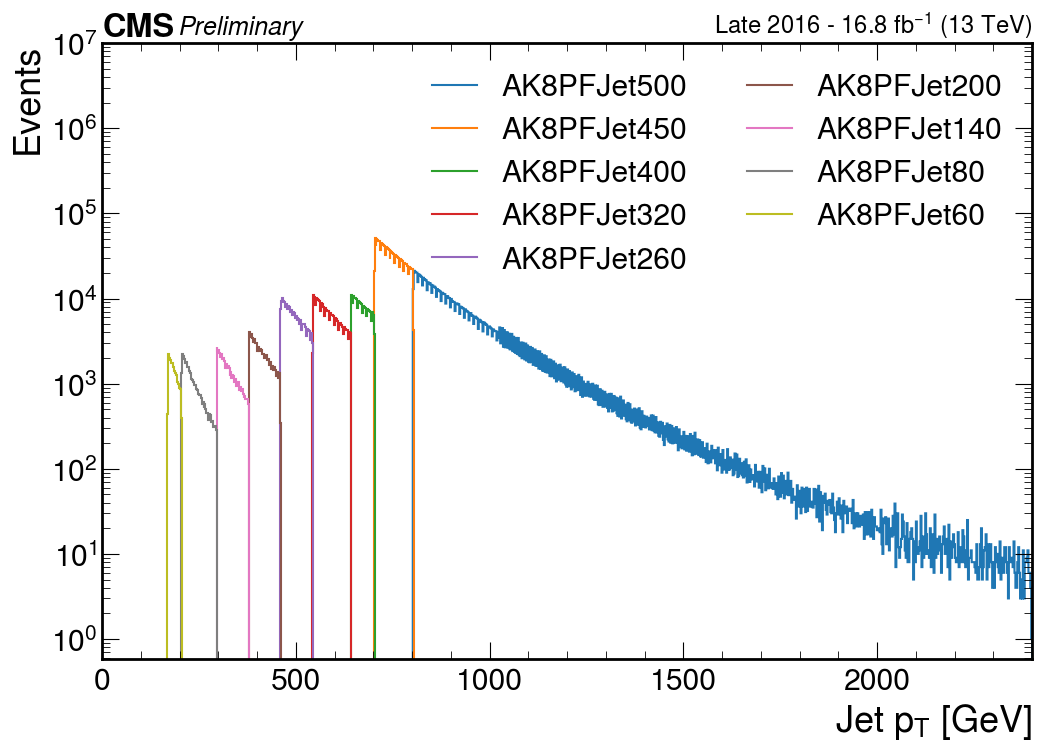

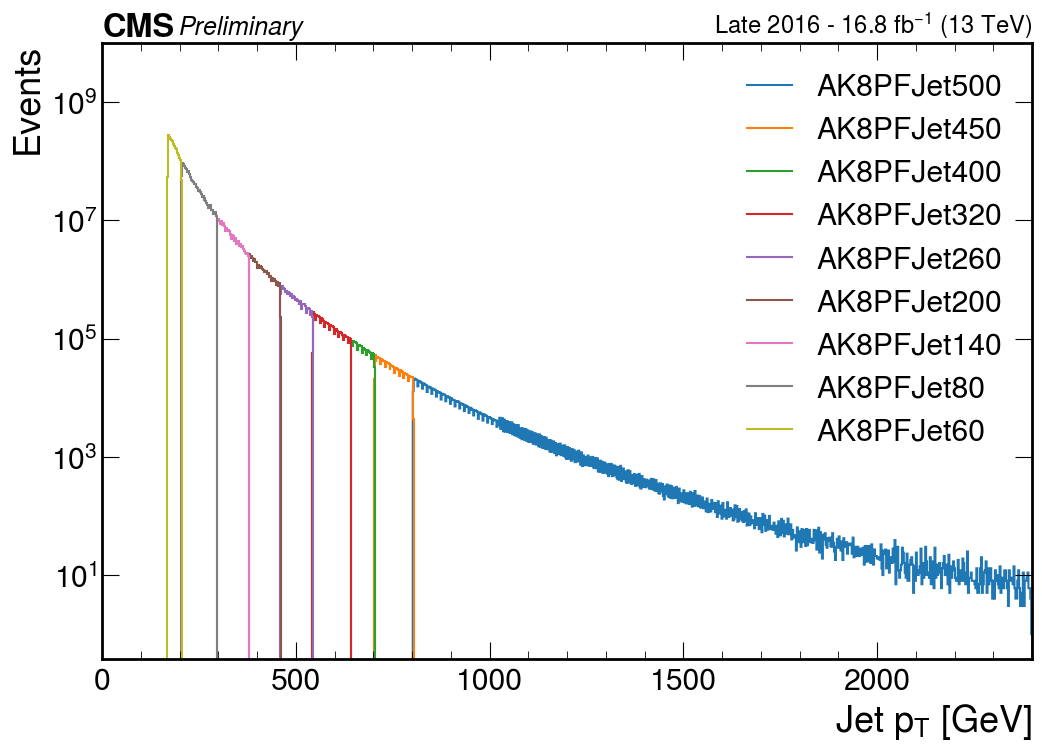

In [21]:
with open("coffeaOutput/applyPrescales_latest_JetHT_2016_AK8PFJet.pkl", "rb") as f:
    result = pickle.load( f )
print(result.keys())
plotPrescales(result, '2016', label=r'Late 2016 - 16.8' )

Hist(
  StrCategory(['AK8PFJet550', 'AK8PFJet500', 'AK8PFJet450', 'AK8PFJet400', 'AK8PFJet320', 'AK8PFJet260', 'AK8PFJet200', 'AK8PFJet140', 'AK8PFJet80', 'AK8PFJet60', 'AK8PFJet40'], growth=True, name='HLT_cat'),
  Regular(1000, 0, 2400, name='pt', label='Jet pT (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=1.23893e+08, variance=1.23893e+08) (WeightedSum(value=1.23904e+08, variance=1.23904e+08) with flow)


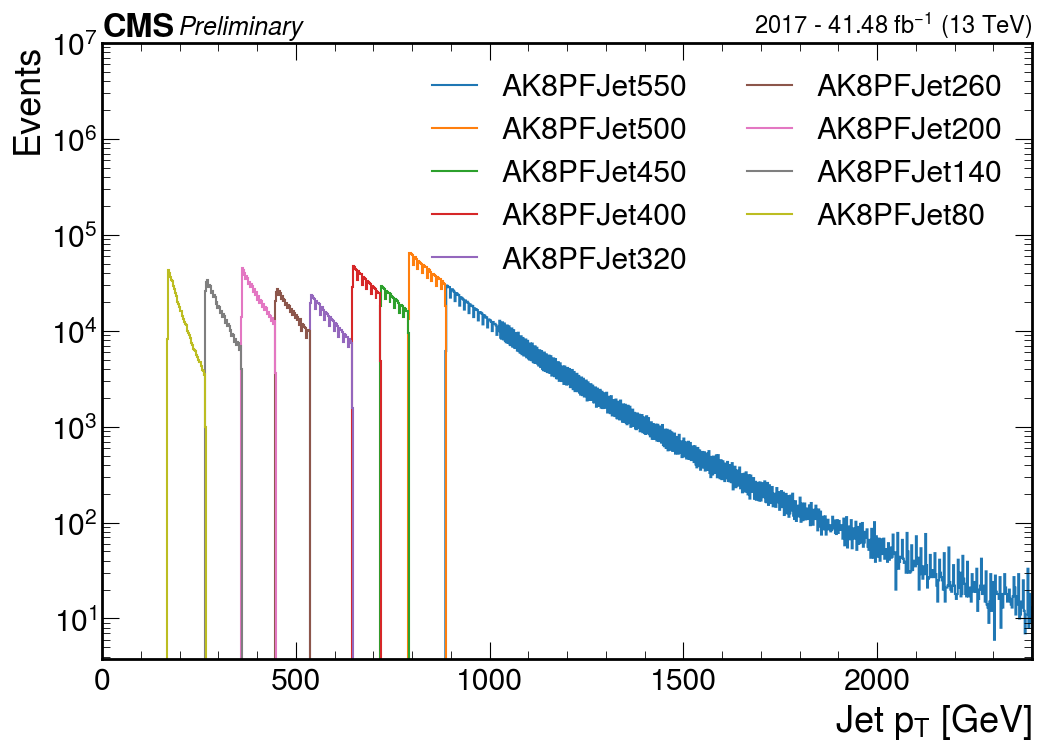

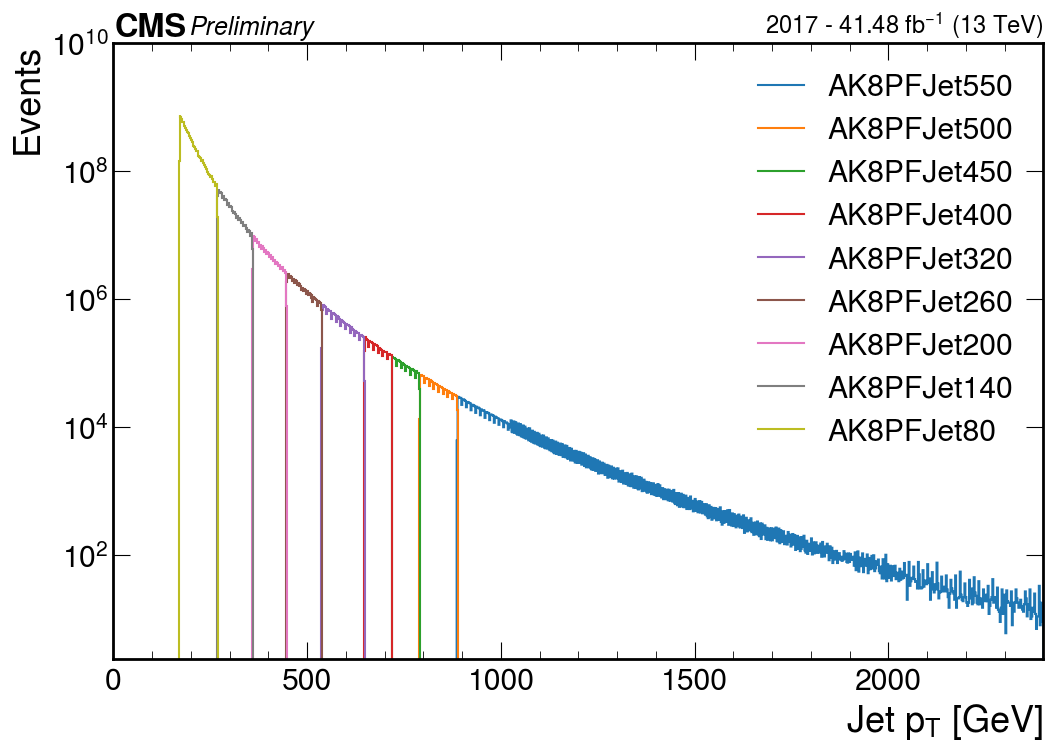

In [22]:
with open("coffeaOutput/applyPrescales_JetHT_2017_AK8PFJet.pkl", "rb") as f:
    result = pickle.load( f )
# print(result['hist_pt'][{'HLT_cat':sum, 'pt':sum}].values())
plotPrescales(result, '2017', label=r'2017 - 41.48',)

Hist(
  StrCategory(['AK8PFJet500', 'AK8PFJet450', 'AK8PFJet400', 'AK8PFJet320', 'AK8PFJet260', 'AK8PFJet200', 'AK8PFJet140', 'AK8PFJet80', 'AK8PFJet60', 'AK8PFJet40'], growth=True, name='HLT_cat'),
  Regular(1000, 0, 2400, name='pt', label='Jet pT (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=7.00797e+07, variance=7.00797e+07) (WeightedSum(value=7.00887e+07, variance=7.00887e+07) with flow)


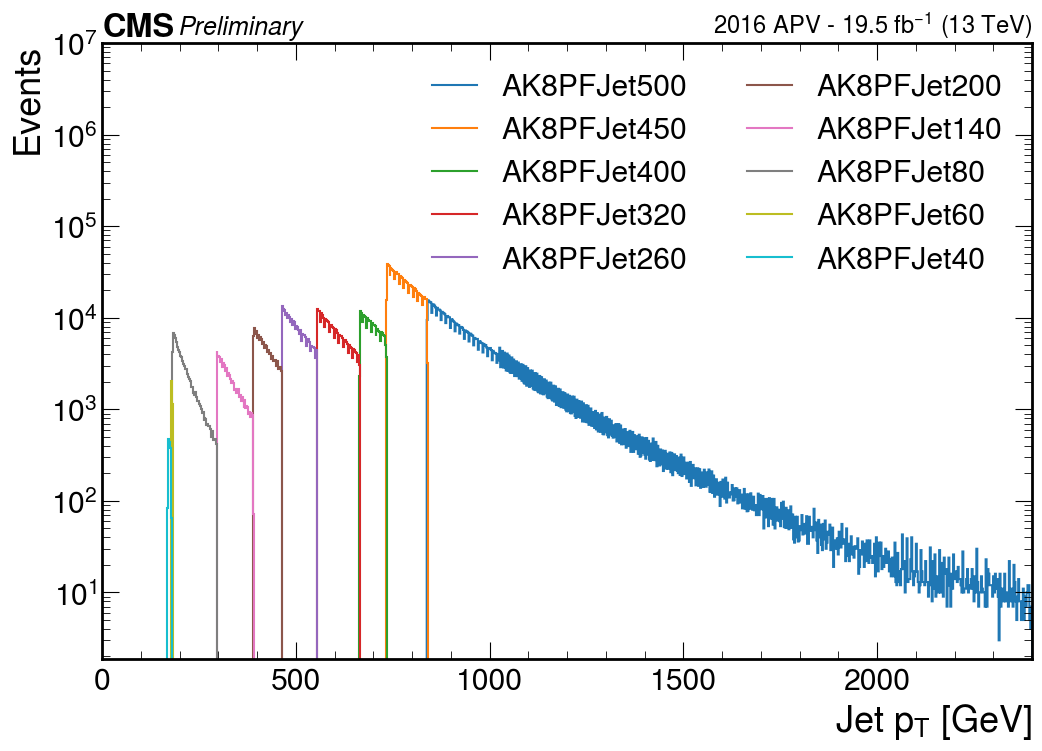

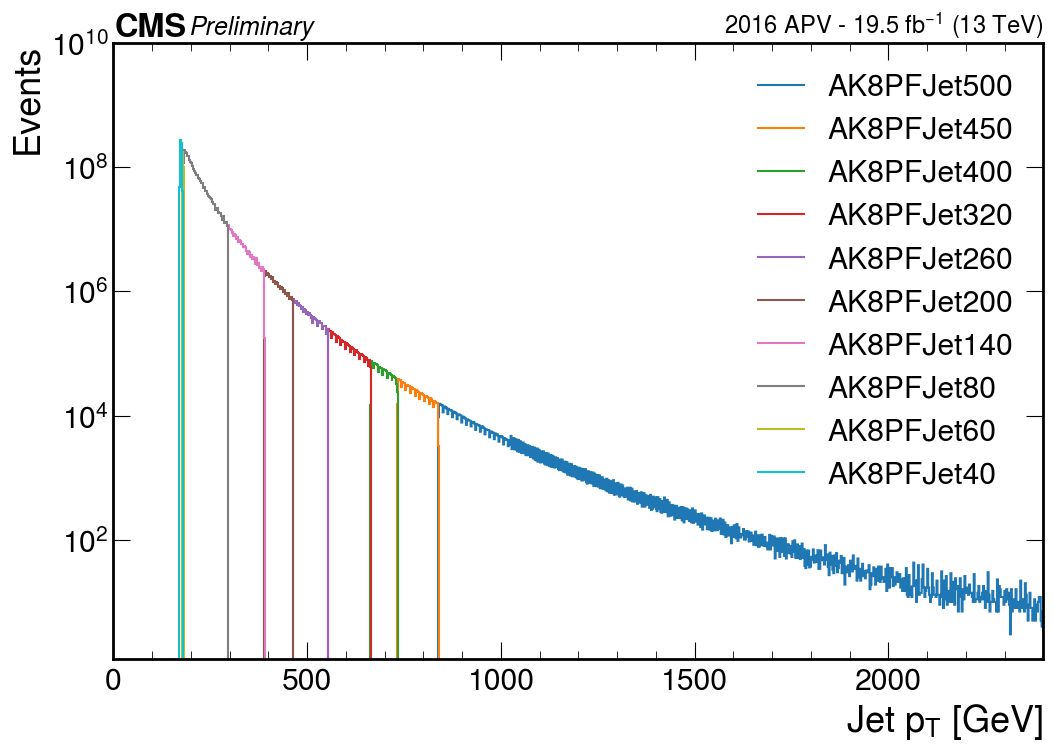

In [23]:
with open("coffeaOutput/applyPrescales_latest_JetHT_2016APV_AK8PFJet.pkl", "rb") as f:
    result = pickle.load( f )
# print(result['hist_pt'][{'HLT_cat':sum, 'pt':sum}].values())
plotPrescales(result, '2016APV', label=r'2016 APV - 19.5')

Hist(
  StrCategory(['AK8PFJet550', 'AK8PFJet500', 'AK8PFJet450', 'AK8PFJet400', 'AK8PFJet320', 'AK8PFJet260', 'AK8PFJet200', 'AK8PFJet140', 'AK8PFJet80', 'AK8PFJet60', 'AK8PFJet40'], growth=True, name='HLT_cat'),
  Regular(1000, 0, 2400, name='pt', label='Jet pT (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=1.23984e+08, variance=1.23984e+08) (WeightedSum(value=1.23992e+08, variance=1.23992e+08) with flow)


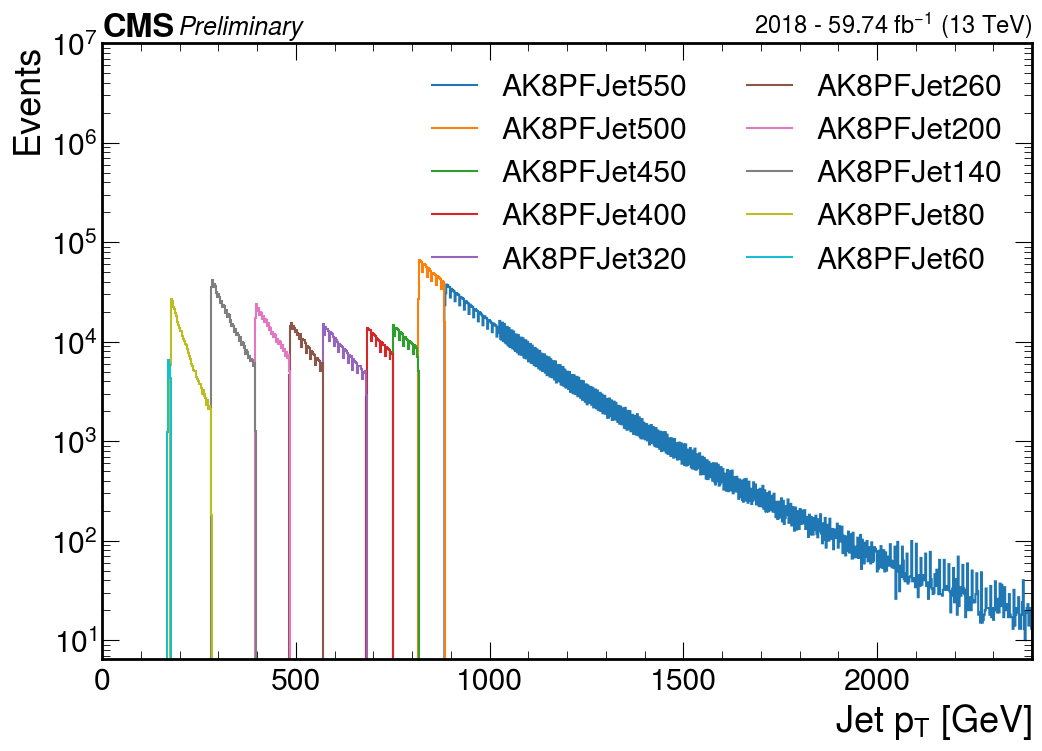

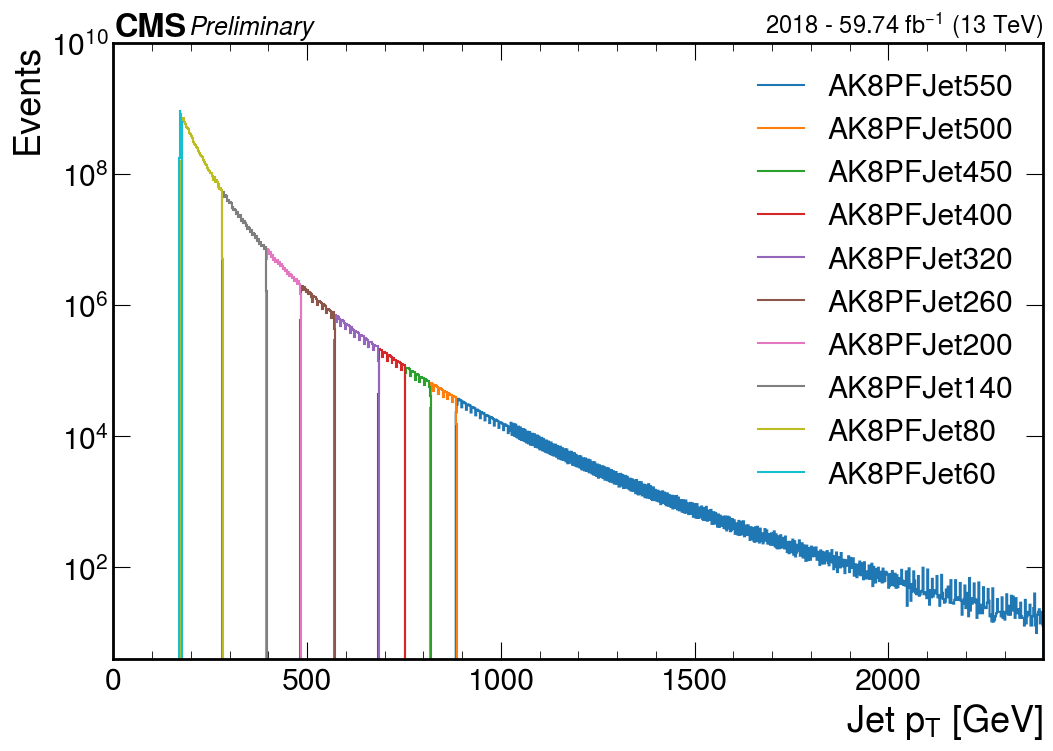

In [24]:
with open("coffeaOutput/applyPrescales_JetHT_2018_AK8PFJet.pkl", "rb") as f:
    result = pickle.load( f )
# print(result['hist_pt'][{'HLT_cat':sum, 'pt':sum}].values())
plotPrescales(result, '2018', label=r'2018 - 59.74',)